## imports

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Module to load MATLAB .mat datafile format (Input and output module of scipy)
from scipy.io import loadmat


# figure size, dpi and font size
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14

## Multi-class Classification

For this exercise, OnevsAll Classifier will be used to recognize handwritten digits (from 0 to 9).


### Dataset

The data set is given in `mnist-digit.mat` that contains 5000 training examples of handwritten digits. Use the function `loadmat` within the `scipy.io` module to load the data.

There are 5000 training examples in `mnist-digit.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set.


- loading the data using `loadmat` function from `scipy.io` module

In [2]:
digits = loadmat('data/mnist-digit.mat')

- let's see the shape of the data

In [3]:
# printing out all the keys
print(sorted(digits.keys()))

print(f" X: {digits['X'].shape} y: {digits['y'].shape} ")

print(f"Unique labels:  {np.unique(digits['y'])}")


['X', '__globals__', '__header__', '__version__', 'y']
 X: (5000, 400) y: (5000, 1) 
Unique labels:  [ 1  2  3  4  5  6  7  8  9 10]


- mapping 10 to 0

In [4]:
# mapping 0 to label 10
digits["y"][digits["y"] == 10] = 0

# printing the unique values of the labels
print(f"Unique labels:  {np.unique(digits['y'])}")

Unique labels:  [0 1 2 3 4 5 6 7 8 9]


In [5]:
# Reshape the y array from (5000, 1) to (5000,)
digits["y"] = digits["y"].reshape(-1,)

# printing the shape of the y array
print(f"Shape of y: {digits['y'].shape}")

Shape of y: (5000,)


### 1. Inspect and plot some portion of the training data. Segregate the data into two separate variables consisting of ‘feature matrix’ and corresponding ‘labels’. Plot some example images along with their descriptive labels.

- Splitting the data into training and test sets (70% training and 30% test)

In [6]:
# Randomly shuffle the data
shuffled_indices = np.random.permutation(digits["X"].shape[0])

# Select 70-30 for train and test
n = digits["X"].shape[0]

# storing the features and labels in different vaariable for both 
X_train = digits["X"][shuffled_indices[:7*n//10], :]
y_train = digits["y"][shuffled_indices[:7*n//10]]

X_test = digits["X"][shuffled_indices[7*n//10:], :]
y_test = digits["y"][shuffled_indices[7*n//10:]]

# printing the shape of the training and test data
print(f"X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} y_test: {y_test.shape}")

X_train: (3500, 400) y_train: (3500,)
X_test: (1500, 400) y_test: (1500,)


- let's write a function to randomly plot some images from the training set

In [7]:
def plot_grid(n, X, y):
    labels = np.unique(y)
    fig, axes = plt.subplots(n, len(labels), figsize=(10, 8))
    for j, label in enumerate(labels):
        selected_rows = X[y == label]
        for i in range(n):
            # print(i, j)
            selected_row = selected_rows[np.random.randint(0, selected_rows.shape[0])]
            axes[0, j].set_title(j, fontsize=8)
            axes[i, j].imshow(selected_row.reshape( 20, 20).transpose( ), cmap='gray')
            axes[i, j].axis('off')
        
    return fig

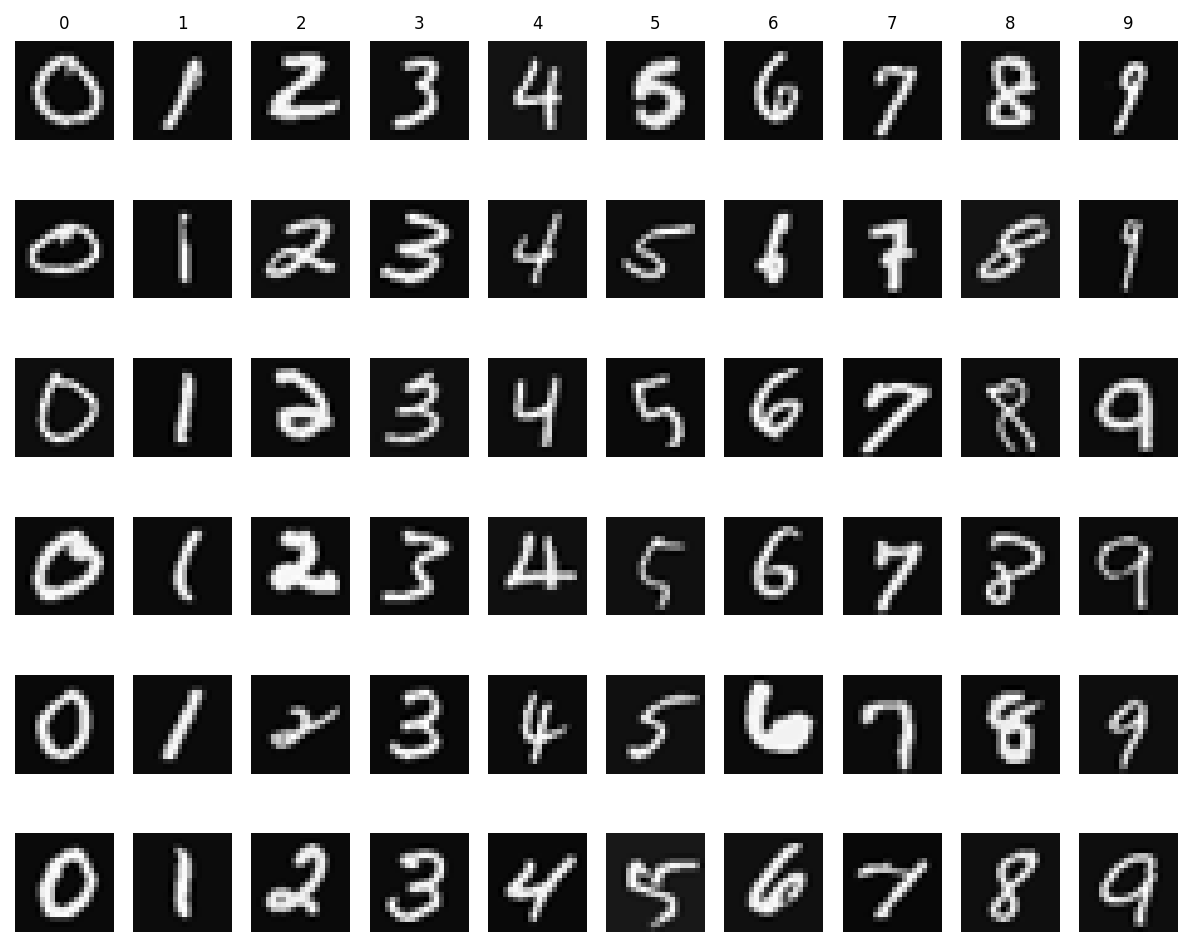

In [8]:
# plotting the images
fig = plot_grid(n=6, X= X_train, y= y_train);
fig.savefig("figures/0101.png")

### 2. Classify the dataset using one-vs-all multi-class classification algorithm and calculate the optimized weights and training set accuracy for the model (use Conjugate Gradient algorithm for optimization).

### Vectorizing the cost function 

Begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_w\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_w \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_w(x^{(i)})$ for every example $i$, where $h_w(x^{(i)}) = g(w^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $w$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad w = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{bmatrix} $$

Then, by computing the matrix product $Xw$, we have: 

$$ Xw = \begin{bmatrix} - \left( x^{(1)} \right)^Tw - \\ - \left( x^{(2)} \right)^Tw - \\ \vdots \\ - \left( x^{(m)} \right)^Tw - \end{bmatrix} = \begin{bmatrix} - w^T x^{(1)}  - \\ - w^T x^{(2)} - \\ \vdots \\ - w^T x^{(m)}  - \end{bmatrix} $$

### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_w\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $w_j$,

$$  \begin{bmatrix} \frac{\partial J}{\partial w_0} \\ \frac{\partial J}{\partial w_1} \\ \frac{\partial J}{\partial w_2} \\ \vdots \\ \frac{\partial J}{\partial w_n} \end{bmatrix}  = \frac{1}{m} \begin{bmatrix} \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\ \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\ \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\ \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\ \end{bmatrix} \\ $$

$$ = \frac{1}{m} \sum_{i=1}^m \left( \left(h_w\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\ $$

$$ = \frac{1}{m} X^T \left( h_w(x) - y\right)$$

where

$$  h_w(x) - y = 
\begin{bmatrix}
h_w\left(x^{(1)}\right) - y^{(1)} \\
h_w\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_w\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Note that $x^{(i)}$ is a vector, while $h_w\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_w\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_w(x^{(i)} - y^{(i)} \right)$.

Now the job is to define a new function (`lrCostFunction`) which will take the data (vectors `X` and `y`) and parameter (`Lambda`) as input and return the cost as a scalar. 

### Regularized logistic regression

Now add regularization to the cost function. For regularized logistic regression, the cost function is defined as

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_w\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_w \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2 $$

Note that $w_0$ should not be regularized as it is used as bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $w_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(w)}{\partial w_0} = \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(w)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} w_j & \text{for } j  \ge 1
\end{align*}

$$

- hence let's write the vectorized version of the gradient for regularized logistic regression:

In [9]:
# function to add 1 as a bias term at index 0
def add_bias(X):
    m = X.shape[0]
    return np.hstack((np.ones((m, 1)), X))

# sigmoid function
def sigmoid(z):
    """
    Computes the sigmoid function of z.
    """
    return 1.0 / (1.0 + np.exp(-z))

# hypothesis function
def hypothesis(w, X):
    """
    Computes the hypothesis function given the weights w and the input X.
    """
    return sigmoid(np.dot(X, w.T))

# cost function
def cost(w, y_true, X_train, lambda_=0):
    """
    Computes the cost function given the weights w, the predicted labels y_hat and the true labels y_true.
    """
    y_hat = hypothesis(w, X_train)

    # number of training examples
    m = y_true.size

    # if labels are Yes/No, map 0/1 to Yes/No.
    if y_true.dtype == bool:
        y_true = y_true.astype(int)
    # print(y_hat.shape, y_true.shape)

    # initialize the cost and gradient
    J = 0
    grad = np.zeros(w.shape)
    
    J = (-1/m)*np.sum(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat+1e-10)) + (lambda_/(2*m)) * np.sum(w[1:]**2)
    grad = (1/m)*np.dot((y_hat - y_true), X_train) + lambda_/m*(np.r_[[[0]],w[1:].reshape(-1,1)].reshape(-1,))

    return J, grad


- let's write a callback function to get the loss and accuracy of the model on the training and validation set at each iteration.

In [10]:
X_te = add_bias(X_test)
def loss_history_callback(all_w, X, y, lambda_, train_loss, test_loss, i):
    """
    Callback function to record the loss history for each iteration and for each class
    """
    def callback(w):
        # calculate the loss for the current weights
        train_loss_his = cost(w, y, X, lambda_)

        test_loss_his = cost(w, y_test==i, X_te, lambda_)

        
        # record the current loss in the loss history
        # loss_history[i].append(train_loss_his)
        # in current loss, it is a tuple where first element 
        # is the loss and second element is the the weights and 
        # this is for each iteration so we skip the weights and append the loss
        train_loss[i].append(train_loss_his[:][0])
        test_loss[i].append(test_loss_his[:][0])

        
    return callback


- let's write a oneVsAll function that will train multiple regularized logistic regression classifiers and return all the classifiers in a matrix `all_w`, where the $i^{th}$ row of `all_w` corresponds to the classifier for label $i$.

In [11]:
# one vs all function
def oneVsAll(X, y, num_labels, lambda_=0.1, max_itr=1000):
    """
    Trains num_labels logistic regression classifiers and returns all the classifiers in a matrix all_w, where the i-th row of all_w corresponds to the classifier for label i.
    """
    # number of training examples and features
    m, n = X.shape
    
    # add ones to the X data matrix
    X = add_bias(X)
     
    # initialize the all_w matrix
    all_w = np.zeros((num_labels, n + 1))

    # initialize the loss history for each label (list of lists) 
    train_loss = [[] for _ in range(num_labels)]
    test_loss = [[] for _ in range(num_labels)]

    
    # optimize the weights for each label
    for i in range(num_labels):

        # initialize the weights
        initial_w = np.random.uniform(low=-1,high=1, size=n+1)

        # create a callback function with the current label and loss history
        current_y = (y == i)
        callback = loss_history_callback(all_w, X, current_y, lambda_, train_loss, test_loss, i)

        # optimize the weights using Conjugate Gradient Descent
        res = optimize.minimize(cost, initial_w, args=(current_y,X, lambda_), jac=True, callback=callback, options={'maxiter':max_itr}, tol=1e-10,  method="CG")
        # store the optimized weights in the i-th row of all_w
        all_w[i] = res.x
    
    return all_w, train_loss, test_loss

- let's write the function to predict the label by considering that say which is maximum. It means we will calculate the probability of belonging to each class but final answer will be that which is maximum

In [12]:
def predictOneVsAll(all_w, X):
        
    m = X.shape[0]
    num_labels = all_w.shape[0]

    # Return the following variable 
    p = np.zeros(m)

    # add ones to the X data matrix (bias term)
    X = add_bias(X)

    # retrun the class with max prob 
    p = np.argmax(sigmoid(np.dot(X,all_w.T)), axis=1)   # A vector of size 10 X 1 -> Keep in the class having max prob
    
    return p

- here we have one hyperparameter $\lambda$, so first let's try to tune that by training the data for only 50 iterations and then plot the accuracy vs $\lambda$

In [13]:
X = digits["X"]
y = digits["y"].reshape(-1,)

In [14]:
# store the accuracy values
accur_ = []
for i in np.linspace(0.01, 2, 20):
    # train the model
    all_w, train_loss, test_loss = oneVsAll(X, y, 10, lambda_=i, max_itr=50)

    # predict the labels
    p = predictOneVsAll(all_w, X_train)

    # calculate the accuracy
    accuracy = np.mean(p == y_train) * 100

    accur_.append(accuracy)

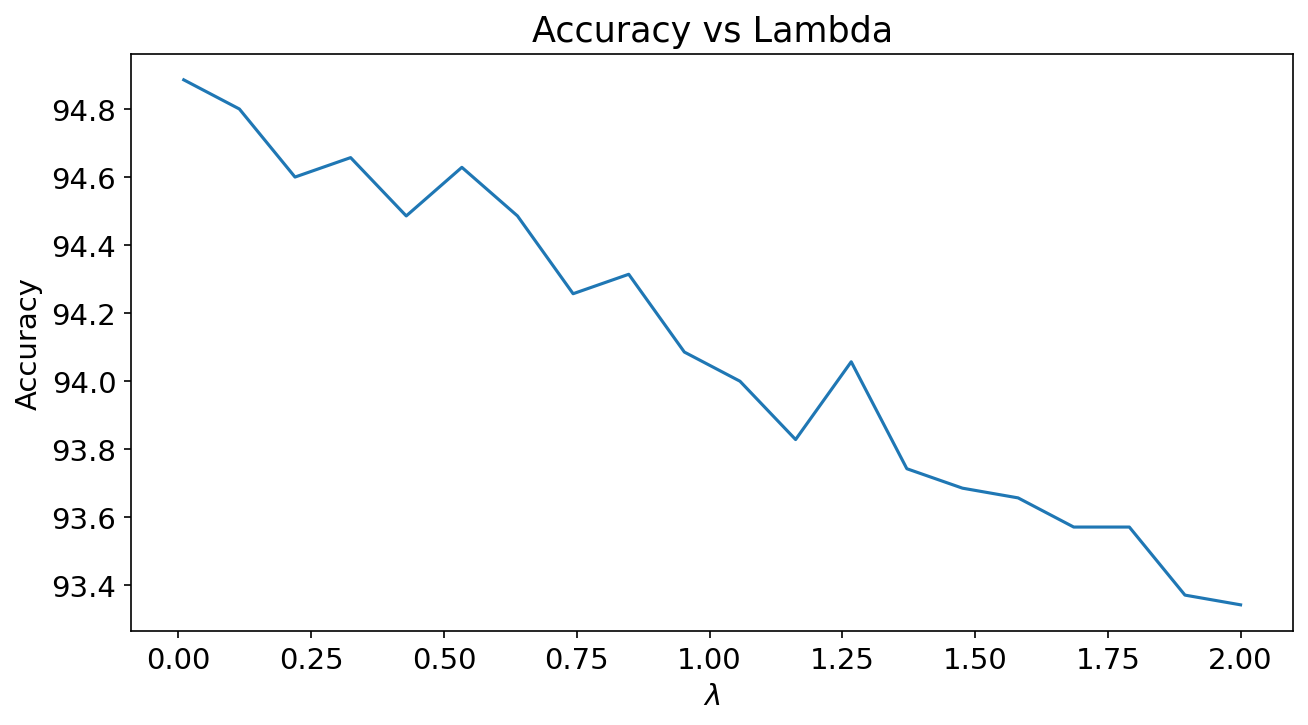

In [15]:
lambda_ = np.linspace(0.01, 2, 20)
plt.plot(lambda_, accur_)
plt.xlabel("$\lambda$")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Lambda")
plt.savefig("figures/0102")

- So we can see here that for very small value of $\lambda$ our accuracy is good. so training the main model for $\lambda$ = 0.03

In [16]:
np.random.seed(42)
lambda_ = 0.03
X = digits["X"]
y = digits["y"].reshape(-1,)
all_w, train_loss, test_loss = oneVsAll(X, y, 10, lambda_)
print(all_w.shape) # 10 X 401

(10, 401)


### 3. Plot the cost history (J) vs number of iterations for all the class labels in a single plot.

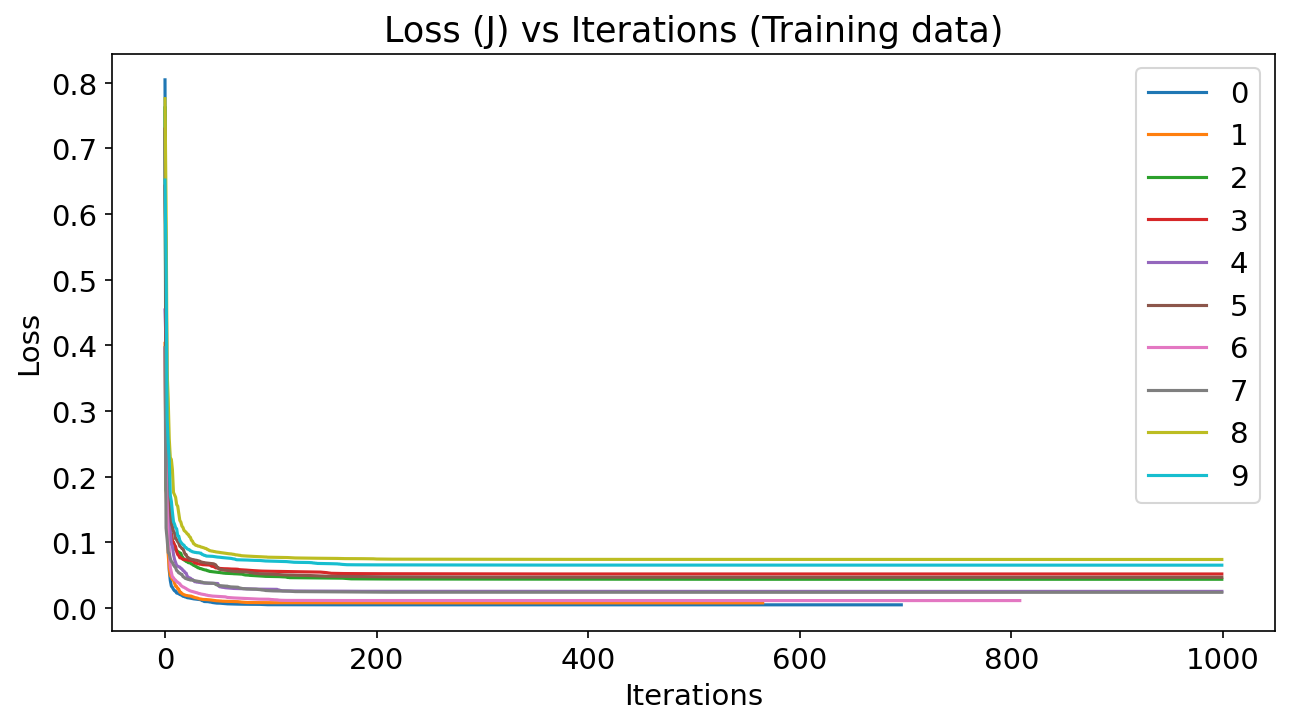

In [17]:
# Plot the loss history for each class
for i in range(10):
    plt.plot(train_loss[i], label=str(i))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

plt.title("Loss (J) vs Iterations (Training data)")
plt.savefig("figures/0103.png")

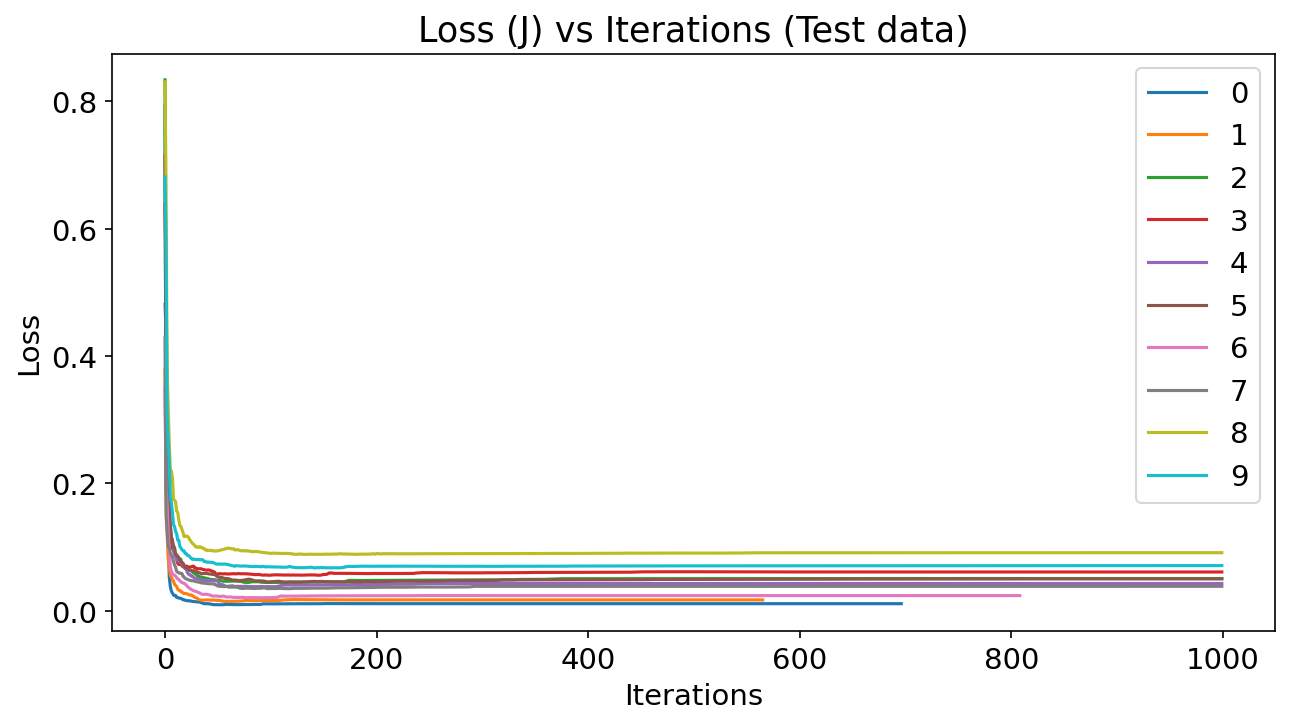

In [18]:
# Plot the loss history for each class
for i in range(10):
    plt.plot(test_loss[i], label=str(i))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

plt.title("Loss (J) vs Iterations (Test data)")
plt.savefig("figures/0104.png")

### 4. Apply the trained model algorithm on the test dataset and predict the testing accuracy of the model.

- let's see some y_test and it's predicted value

In [19]:
y_test

array([2, 6, 9, ..., 0, 4, 4], dtype=uint8)

In [20]:
predictOneVsAll(all_w, X_test)

array([2, 6, 9, ..., 0, 4, 4])

- Now let's see what's the accuracy of our model in training data.

In [21]:
pred_train = predictOneVsAll(all_w, X_train)
accuracy  = np.mean(pred_train == y_train) * 100
print('Training Set Accuracy: {:.2f}%'.format(accuracy) )

Training Set Accuracy: 96.80%


- Accuracy in Test dataset

In [22]:
pred_test = predictOneVsAll(all_w, X_test)
accuracy  = np.mean(pred_test == y_test) * 100
print('Test Set Accuracy: {:.2f}%'.format(accuracy) )

Test Set Accuracy: 97.47%


### 5. Use the test data to plot few images along with the model predicted labels/classes.

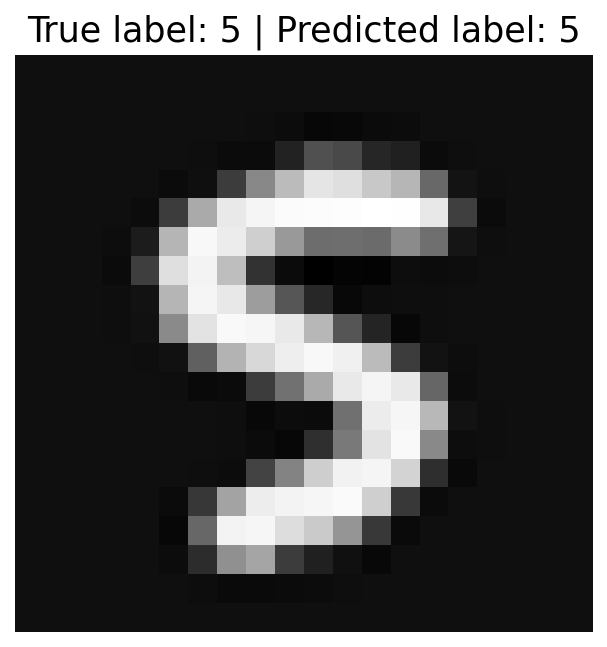

In [23]:
# Function to plot the random image and label it's true and predicted label
def plot_random_img(X, y, p):
    """
    Plots a random image from the dataset X and y, and prints the predicted and true labels.
    """
    # pick a random image
    idx = np.random.randint(0, X.shape[0])
    img = X[idx].reshape(20, 20).T
    pred = p[idx]
    true = y[idx]

    plt.imshow(img, cmap='gray')
    plt.title('True label: {} | Predicted label: {}'.format(true, pred))
    plt.axis('off')
    plt.show()

plot_random_img(X_train, y_train, pred_train)


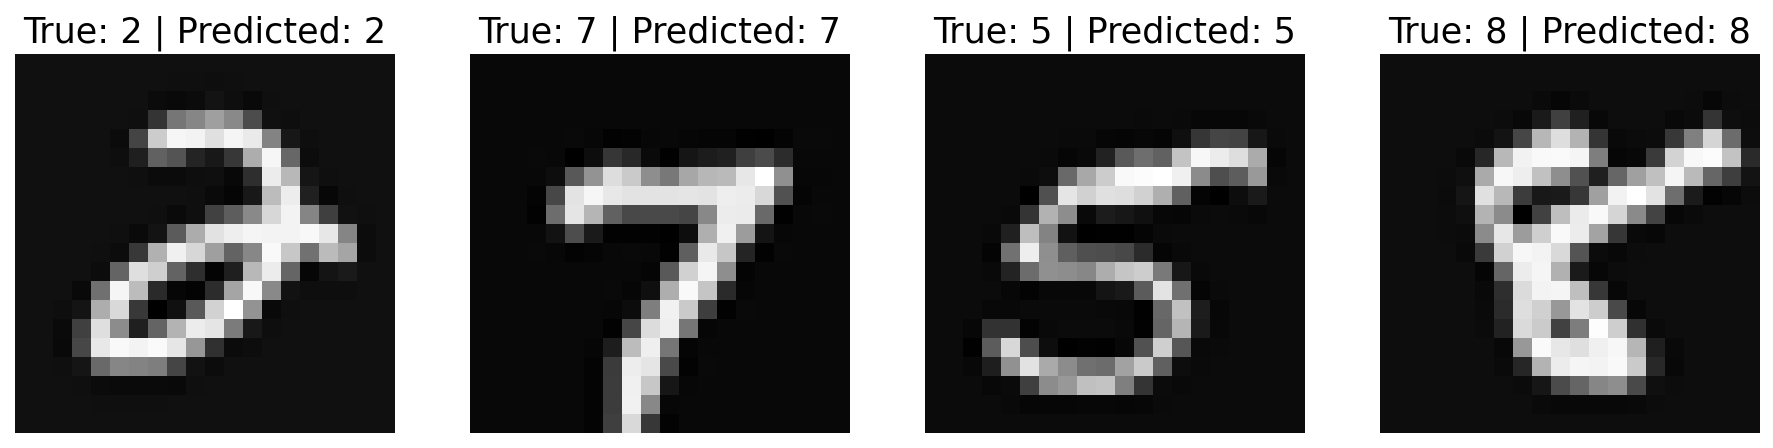

In [25]:
# function to plot n random images from the dataset X and y, and prints the predicted and true labels.
def plot_n_random_img(X, y, p, n):
    """
    Plots n random images from the dataset X and y, and prints the predicted and true labels.
    """
    # pick n random images
    idx = np.random.randint(0, X.shape[0], n)
    imgs = X[idx].reshape(-1, 20, 20).transpose(0, 2, 1)
    preds = p[idx]
    trues = y[idx]

    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i], cmap='gray')
        ax.set_title('True: {} | Predicted: {}'.format(trues[i], preds[i]))
        ax.axis('off')
    plt.savefig("figures/0105.png")


plot_n_random_img(X_test, y_test, pred_test, 4)

***